In [1]:
from sshtunnel import SSHTunnelForwarder
from nltk.stem import PorterStemmer 
import spacy
import psycopg2
import gensim
from gensim import models
from nltk.corpus import stopwords
import re
import numpy as np
import pandas as pd
import language_tool_python

import os
import copy
import tqdm
import matplotlib.pyplot as plt

# for T-SNE
from sklearn.manifold import TSNE


In [2]:
def lemmatize(text,nlp):
    # can be parallelized
    doc = nlp(text)
    lemma = [n.lemma_ for n in doc]
    return lemma

def preprocess(text,nlp):
    
    result = []
    for token in gensim.utils.simple_preprocess(text): #  gensim.utils.simple_preprocess tokenizes el texto
        token = ''.join(x for x in token.lower() if x.isalpha())
        if token not in palabrasVacias_nltk and len(token) > 2:
            result.append(token)       
    result = lemmatize(' '.join(result),nlp)
    return result

def remove_words(text):
    # Reemplazar simobolo por palabra para que no me elimine los hashtags
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b','',text, flags=re.MULTILINE) #Remove URL
    text = re.sub(r'@\w+','', text) # remove mentions
    return text

def correct_text(text):
    coincidencias = corrector.check(text)
    corrected = corrector.correct(text)
    return corrected

def load_data(REMOTE_PASSWORD,REMOTE_HOST,REMOTE_SSH_PORT,REMOTE_USERNAME,PORT):
    server = SSHTunnelForwarder((REMOTE_HOST, REMOTE_SSH_PORT),
         ssh_username=REMOTE_USERNAME,
         ssh_password=REMOTE_PASSWORD,
         remote_bind_address=('localhost', PORT),
         local_bind_address=('localhost', PORT))
    server.start()
    DATABASE = "tweetproject"
    USER = "postgres"
    PWD = "padova2021"

    conn = psycopg2.connect(
        database=DATABASE,
        user=USER,
        host=server.local_bind_host,
        port=server.local_bind_port,
        password=PWD)


    cur = conn.cursor()
    #Query of the DB to the table that contains the tweets 
    cur.execute("SELECT full_text FROM public.tweet where lang = 'es';")
    data = cur.fetchall()
    server.close()
    
    #Convert the query into a dataframe of pandas
    tweets_sp = pd.DataFrame(data)
    tweets_sp = tweets_sp.rename(columns={0: 'tweet'})
    
    return tweets_sp


In [3]:
np.random.seed(2022)

corrector = language_tool_python.LanguageTool('es')
nlp = spacy.load('es_core_news_lg')

#Information to connect to the database
REMOTE_PASSWORD ="colombi@2021Prj"
REMOTE_HOST = "147.182.253.185"
REMOTE_SSH_PORT = 22
REMOTE_USERNAME = "root"
PORT=5432

# download the data and store as pandas dataframe
tweets_sp = load_data(REMOTE_PASSWORD,REMOTE_HOST,REMOTE_SSH_PORT,REMOTE_USERNAME,PORT)

# create column for hashtag 
tweets_sp['hashtag'] = tweets_sp['tweet'].apply(lambda x: re.findall(r'#(\w+)', x))
tweets_sp['tweet_c'] = tweets_sp['tweet'].apply(lambda x: remove_words(x))

In [4]:
# define stopwords
palabrasVacias_nltk = stopwords.words('spanish')
palabrasVacias_nltk.append("usted")
palabrasVacias_nltk.append("uds")
palabrasVacias_nltk.append("hacer")
palabrasVacias_nltk.append("bien")
palabrasVacias_nltk.append("navidad")
palabrasVacias_nltk.append("jajaja")

# preprocess all tweets and create dictionary
preprocessed_tweets = tweets_sp['tweet_c'].apply(lambda x: preprocess(x, nlp))



In [5]:
dictionary_spanish = gensim.corpora.Dictionary(preprocessed_tweets)

    
#Distribucion de las palabras para resolver el cutter  
#########################  

# filter extreme values in dictionary.
# i.e. remove all words which occur less than 10 times or in more than 50% of all documents
dictionary_spanish.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
dictionary_spanish.most_common()[:10]
dictionary_spanish.most_common()[-10:]

# manually add words that should be deleted
# assume the word 'b' is to be deleted, put its id in a variable

words_to_del = ['ver','mas','cómo','así','cuál','tal','dejar','jajajajajaja','jajajajaja','hacer','afinia','decir','ser','ir','señor','salir','jajajaja','asi','bla','jajajajajajaja','siguemeytesigo','siganme','síganme']
for i in words_to_del:
    del_ids = [k for k,v in dictionary_spanish.items() if v==i]
    dictionary_spanish.filter_tokens(bad_ids=del_ids)

# create the corpus
bow_corpus = [dictionary_spanish.doc2bow(doc) for doc in preprocessed_tweets]

# save the bow_corpus for later use
import json
# save as json
with open('final_lda_model/bow_corpus.json', 'w') as f:
    json.dump(bow_corpus,f)

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [6]:
## run LDA
n_cores = os.cpu_count()-1

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=16, id2word=dictionary_spanish, 
                                             random_state=100,
                                             iterations = 400,
                                             passes=40,
                                             workers=n_cores)

In [7]:
def get_topics(lda_model_tfidf,tfidf_vector,cutoff = .1):
    tpcs = sorted(lda_model_tfidf[tfidf_vector], key=lambda tup: -1*tup[1])
    topics_per_tweet = [(tpc,prob) for tpc,prob in tpcs if prob > cutoff]
    if len(topics_per_tweet) == 0:
        topics_per_tweet = [(np.nan,np.nan)]
    return topics_per_tweet

def make_tfidf_vec(tweet,tfidf):
    bw_vect = dictionary_spanish.doc2bow(preprocess(tweet,nlp))
    tfidf_vec = tfidf[bw_vect]
    return tfidf_vec

In [8]:
# get topics for each tweet (this takes some time)
topics_all = []
for tweet in tqdm.tqdm(tweets_sp['tweet_c']):
    tweet_tfidf = make_tfidf_vec(tweet,tfidf)
    topics_all.append(get_topics(lda_model_tfidf,tweet_tfidf))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53770/53770 [10:19<00:00, 86.86it/s]


In [9]:
tweets_out = copy.deepcopy(tweets_sp) 
tweets_out["tweet_processed"] = preprocessed_tweets
tweets_out['topics'] = [[i[0] for i in j] for j in topics_all]
tweets_out['probs_per_topic'] = [[round(i[1]*100,2) for i in j] for j in topics_all]
tweets_out['dominant_topic'] = [j[0] for j in tweets_out['topics']]
tweets_out['dominant_topic_prob'] = [i[0] for i in tweets_out['probs_per_topic']]

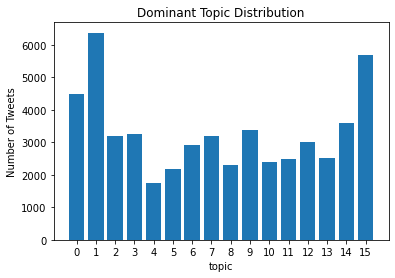

In [10]:
topic_count = np.zeros(16)
for j in range(len(tweets_out)):
    dominant_topic = tweets_out['dominant_topic'][j]
    if not np.isnan(dominant_topic):
        topic_count[int(dominant_topic)] += 1 

plt.bar(x = range(16), height = topic_count)
plt.xlabel("topic")
plt.xticks(ticks = range(16),labels = range(16))
plt.ylabel("Number of Tweets")
plt.title("Dominant Topic Distribution")
plt.show()

In [11]:
topic_words = pd.DataFrame()
topic_words = pd.DataFrame(lda_model_tfidf.show_topic(0,topn = 20))
topic_words = pd.concat([topic_words,pd.Series([],dtype = int)],axis = 1)
topic_words.columns = ['words_'+str(0),'importance_'+str(0),""]
topic_words['importance_0'] = round(topic_words['importance_0']*100,2)
for j in range(15):
    j +=1 
    new_topic = pd.DataFrame(lda_model_tfidf.show_topic(j,topn = 20))
    new_topic = pd.concat([new_topic,pd.Series([],dtype = int)],axis = 1)
    new_topic.iloc[:,1] = round(new_topic.iloc[:,1]*100,2)
    new_topic.columns = ['words_'+str(j),'importance_'+str(j),""]

    topic_words = pd.concat([topic_words,new_topic],axis = 1)
topic_words

,words_0,importance_0,,words_1,importance_1,,words_2,importance_2,,words_3,...,,words_13,importance_13,,words_14,importance_14,,words_15,importance_15,
0,salario,1.17,NaN,paz,1.30,NaN,payaso,2.00,NaN,presidente,...,NaN,feliz,5.63,NaN,pacto,1.46,NaN,salud,0.89,NaN
1,millón,0.91,NaN,policía,1.20,NaN,puro,1.23,NaN,petro,...,NaN,año,1.97,NaN,histórico,1.17,NaN,país,0.82,NaN
2,impuesto,0.89,NaN,terrorista,1.10,NaN,mismo,1.10,NaN,gracias,...,NaN,senador,1.57,NaN,dios,1.15,NaN,tlc,0.68,NaN
3,pagar,0.76,NaN,excelente,1.08,NaN,cuento,1.04,NaN,colombia,...,NaN,voto,1.23,NaN,votar,0.79,NaN,colombia,0.67,NaN
4,mínimo,0.76,NaN,justicia,1.07,NaN,cinismo,1.02,NaN,gustavo,...,NaN,familia,1.04,NaN,apoyo,0.75,NaN,corrupción,0.64,NaN
5,año,0.69,NaN,farc,1.06,NaN,hambre,0.97,NaN,bendición,...,NaN,mejor,0.96,NaN,senado,0.69,NaN,problema,0.63,NaN
6,subir,0.65,NaN,fuerza,0.87,NaN,populismo,0.92,NaN,claro,...,NaN,cambio,0.92,NaN,hermoso,0.66,NaN,educación,0.60,NaN
7,menos,0.61,NaN,asesinar,0.78,NaN,pobre,0.91,NaN,gracia,...,NaN,nuevo,0.83,NaN,roy,0.64,NaN,noticia,0.54,NaN
8,empresa,0.60,NaN,cárcel,0.70,NaN,pendejo,0.84,NaN,poder,...,NaN,vergüenza,0.81,NaN,total,0.63,NaN,poder,0.53,NaN
9,mil,0.58,NaN,impunidad,0.67,NaN,idiota,0.84,NaN,hpto,...,NaN,presidente,0.71,NaN,senador,0.62,NaN,colombiano,0.48,NaN


In [12]:
topic_words.to_excel("Topics.xlsx", index = False)
tweets_out.to_excel("Classified_Tweets.xlsx",index = False)
lda_model_tfidf.save("final_lda_model/final_lda_model.model")

## T-SNE to plot classes
t-SNE to reduce dimensionality of the output and then plot. However, classes don't seem to separate well... If you run it, it will take ages (~20 mins).

In [103]:
hm = np.array([[y for (x,y) in lda_model_tfidf[corpus_tfidf[i]]] for i in range(len(corpus_tfidf))])
hm = hm[np.amax(hm,axis = 1) > 0.35]

In [105]:
tsne = TSNE(random_state=2017, perplexity=60, early_exaggeration=100,init = 'pca',verbose = 0)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

/Users/Nathanael/.conda/envs/SW3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(

/Users/Nathanael/.conda/envs/SW3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(



In [106]:
colors = ['red','blue','green','yellow','olive','magenta','steelblue','lightsalmon','brown','silver','black','turquoise','teal','peru','orange','pink','blueviolet']
color_dict = dict(zip(list(range(16)),colors))
embedding['color'] = np.array([color_dict[t] for t in embedding['hue']])

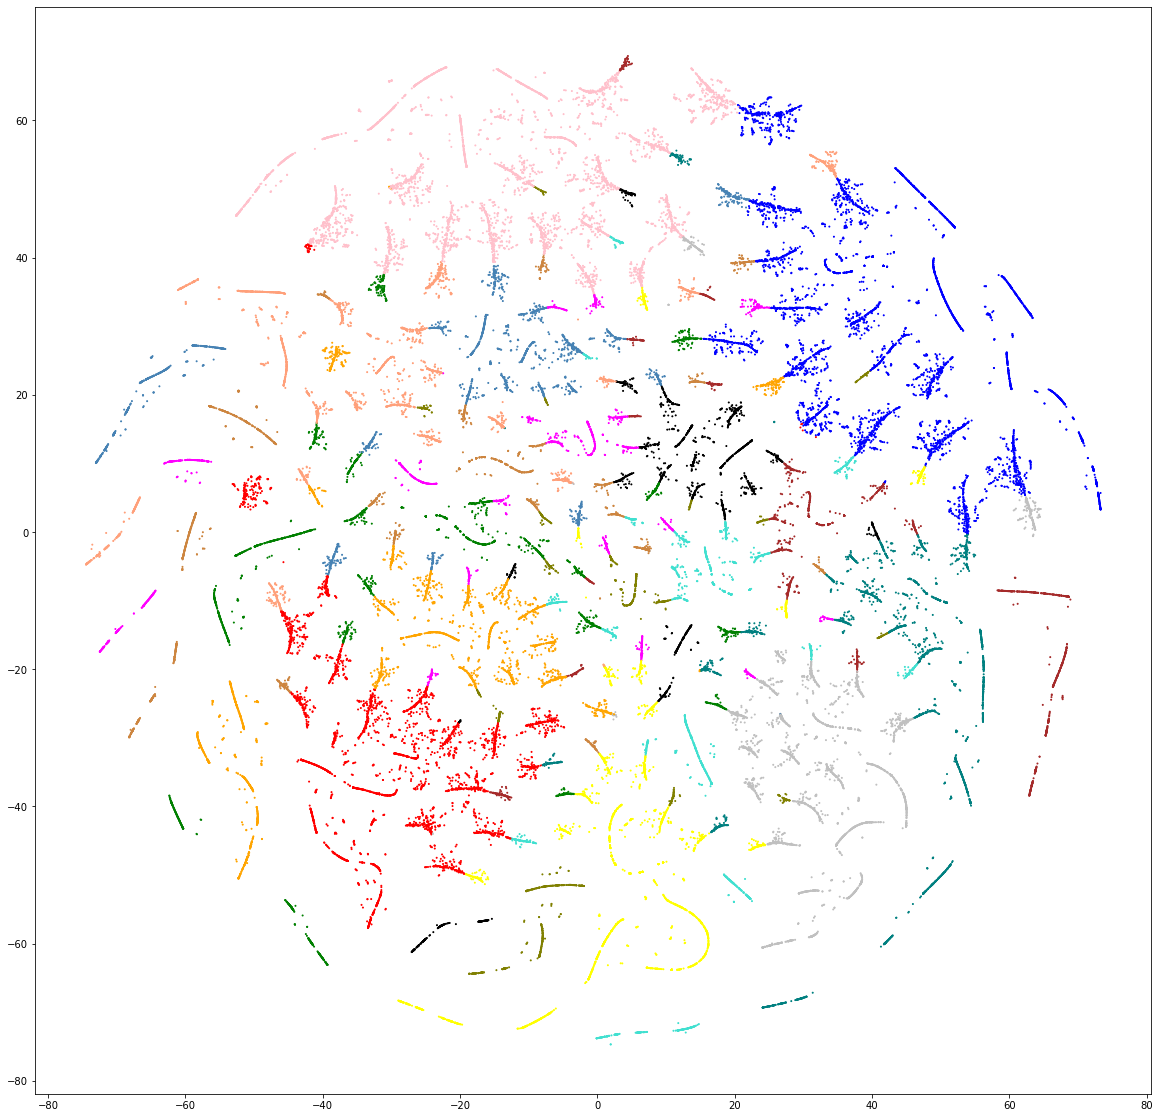

In [107]:
plt.figure(figsize = (20,20))
plt.scatter(x = embedding['x'], y = embedding['y'], c = embedding['color'], s = 1)

## Upload classes

In [ ]:
# load the data 